In [1]:
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
from models_module import my_models
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from fastai.vision.all import URLs
from batchflow import Pipeline, B, C, D, F, V, W
from batchflow.models.torch import UNet, VGG7
from batchflow.models.torch import EncoderDecoder
from batchflow.models.torch.layers import ConvBlock
from batchflow.opensets import MNIST, Imagenette160
from train_module import training_functions

GRAPH_PATH = "./data/graphs/"
IMAGE_SHAPE = (3, 160, 160)

In [2]:
dataset = Imagenette160(bar=True)

 50%|█████     | 1/2 [00:05<00:05,  5.42s/it]


In [3]:
in_channels = 3
out_channels = 3
downsample_depth = 4
device = "cuda:2"

batch_size = 64
epoch_num = 50

In [4]:
model_config = { 
    'device': device,

    'body/encoder': {
        'num_stages': downsample_depth,
        'order': ['block', 'downsampling']
    },    
    'body/encoder/blocks': {
        'layout': 'cna cna',
        'filters': [in_channels*pow(2, i) for i in range(1, downsample_depth+1)]
    },
    'body/encoder/downsample': {
        'layout': 'p'
    },    
    
    'body/embedding': {
        'layout': 'cna cna', 
        'filters': in_channels*pow(2, downsample_depth)
    },   

    'body/decoder': {
        'num_stages': downsample_depth, 'skip': False,
        'order': ['upsampling', 'block']       
    },
    'body/decoder/upsample': {
        'layout': 'tna',
        'filters': [in_channels*pow(2, i-1) for i in range(downsample_depth, -1, -1)]
    },
    'body/decoder/combine': {
        'op': 'concat'
    },
    'body/decoder/blocks': {
        'layout': 'cna cna',
        'filters': [in_channels*pow(2, i-1) for i in range(downsample_depth, -1, -1)]
    },
    'head':{
        'layout': 'ca',
        'filters': in_channels,
        'activation': 'sigmoid'
    },
    
    'loss': 'mse',
    'optimizer': 'Adam'
}

In [5]:
train_pipeline = (dataset.train.p
                .crop(shape=(160, 160), origin='center')
                .init_variable('loss_history', [])
                .to_array(channels='first', dtype=np.float32)
                .multiply(1./255)
                .init_model('dynamic', EncoderDecoder, 'unet',
                            config=model_config)
                .train_model('unet', B.images, B.images, 
                             fetches='loss', save_to=V('loss_history', mode='a'), use_lock=True)
)

In [6]:
train_pipeline.run(64, n_iters=50, bar='n')

  0%|                                                                                                         …

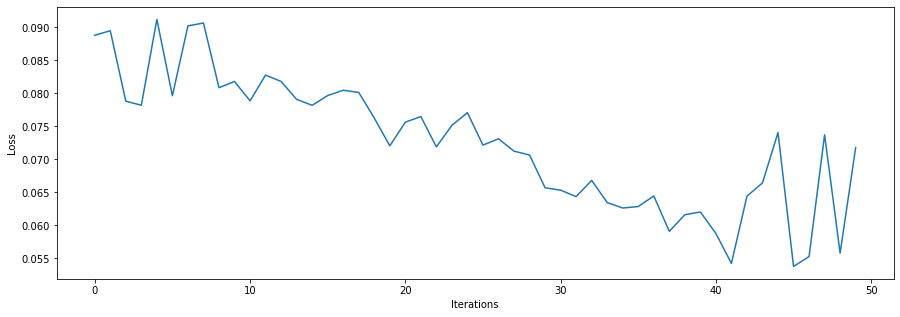

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(train_pipeline.v('loss_history'))
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

In [8]:
pipeline = (dataset.test.p
                .crop(shape=(160, 160), origin='center')
                .to_array(channels='first', dtype=np.float32)
                .multiply(1./255)
                .init_variable('metrics')
                .init_variable('inferred_masks')
                .import_model('unet', train_pipeline)
                .predict_model('unet', fetches='predictions', feed_dict={'x': B('images')},
                               save_to=V('inferred_masks'))
                .gather_metrics('mask', targets=B('images'), predictions=V('inferred_masks'),
                                fmt='proba', axis=-1, save_to=V('metrics', mode='u'))
            )

In [9]:
pipeline.run(64, bar='n')

  0%|                                                                                                         …

In [10]:
metrics = pipeline.get_variable('metrics')
metrics.evaluate(['sensitivity', 'specificity'])

{'sensitivity': 0.45512811801112457, 'specificity': 0.993776898560258}

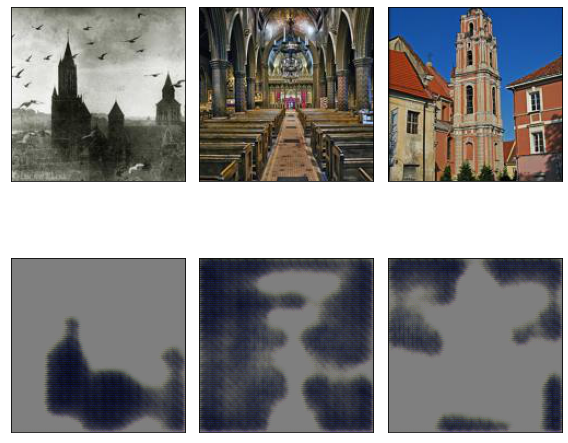

In [11]:
batch = pipeline.next_batch(3)
outputs = pipeline.v('inferred_masks')[:3]
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 8), subplot_kw={'xticks': [], 'yticks': []})

for picture_num, ax in enumerate(axs.flat):
    if picture_num<3:        
        ax.imshow(np.moveaxis(batch.images[picture_num], 0, -1))
    else:
        ax.imshow(np.moveaxis(outputs[picture_num-3], 0, -1))


plt.tight_layout()
plt.show()